In [1]:
%load_ext autoreload
%autoreload 2

# Truncation Methods for TTN

In [23]:
from copy import deepcopy
from enum import Enum
from time import time
from typing import List

from numpy import asarray, eye, abs, zeros, log10
from matplotlib.pyplot import subplots, show
from matplotlib import colormaps

from pytreenet.time_evolution import SecondOrderTwoSiteTDVP
from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.core.node import Node
from pytreenet.operators import (TensorProduct, Hamiltonian)
from pytreenet.operators.common_operators import pauli_matrices
from pytreenet.ttno import TreeTensorNetworkOperator
from pytreenet.util.tensor_splitting import SVDParameters
from pytreenet.special_ttn.fttn import ForkTreeProductState

from pytreenet.core.truncation.svd_truncation import svd_truncation
from pytreenet.core.truncation.recursive_truncation import recursive_truncation

## Binary Tree
### Getting a high bond-dimension TTN

In [3]:
def add_children_rec(node_id, depth, final_depth, ttn: TreeTensorNetworkState):
    local_dim = 2
    if depth == final_depth:
        tensor = asarray([1,0], dtype=complex).reshape(1,local_dim)
    else:
        tensor = asarray([1,0], dtype=complex).reshape(1,1,1,local_dim)
    if depth == 0:
        parent_leg = 0
    else:
        parent_leg = 1
    left_node_id = node_id + "L"
    right_node_id = node_id + "R"
    left_node = Node(identifier=left_node_id)
    right_node = Node(identifier=right_node_id)
    ttn.add_child_to_parent(left_node, tensor,
                            0,node_id,parent_leg)
    ttn.add_child_to_parent(right_node,deepcopy(tensor),
                            0,node_id,parent_leg+1)
    if depth != final_depth:
        add_children_rec(left_node_id, depth+1, final_depth, ttn)
        add_children_rec(right_node_id, depth+1, final_depth, ttn)

ttn = TreeTensorNetworkState()
ket_0 = asarray([1,0], dtype=complex)
root_node = Node(identifier="root")
ttn.add_root(root_node,ket_0.reshape(1,1,2))
final_depth = 2
add_children_rec("root", 0, final_depth, ttn)
print(list(ttn.nodes.keys()))
print(len(ttn.nodes))

['root', 'rootL', 'rootR', 'rootLL', 'rootLR', 'rootLLL', 'rootLLR', 'rootLRL', 'rootLRR', 'rootRL', 'rootRR', 'rootRLL', 'rootRLR', 'rootRRL', 'rootRRR']
15


In [4]:
def generate_full_conecction_hamiltonian(ttn: TreeTensorNetworkState) -> Hamiltonian:
    hamiltonian = Hamiltonian()
    for key in ttn.nodes.keys():
        term = TensorProduct({key: "mhZ"})
        hamiltonian.add_term(term)
        for key_other in ttn.nodes.keys():
            term = TensorProduct({key: "mX", key_other: "X"})
            hamiltonian.add_term(term)
    ext_magn = 3.0
    paulis = pauli_matrices()
    conv_dict = {"mX": -1*paulis[0], "X": paulis[0],
                "mhZ": -1*ext_magn*paulis[2],
                "I2": eye(2)}
    hamiltonian.conversion_dictionary = conv_dict
    return hamiltonian

In [5]:
hamiltonian = generate_full_conecction_hamiltonian(ttn)
ttno = TreeTensorNetworkOperator.from_hamiltonian(hamiltonian,
                                                  ttn)

In [6]:
print([(node.identifier, node.shape) for node in ttn.nodes.values()])
print([(node.identifier, node.shape) for node in ttno.nodes.values()])

[('root', (1, 1, 2)), ('rootL', (1, 1, 1, 2)), ('rootR', (1, 1, 1, 2)), ('rootLL', (1, 1, 1, 2)), ('rootLR', (1, 1, 1, 2)), ('rootLLL', (1, 2)), ('rootLLR', (1, 2)), ('rootLRL', (1, 2)), ('rootLRR', (1, 2)), ('rootRL', (1, 1, 1, 2)), ('rootRR', (1, 1, 1, 2)), ('rootRLL', (1, 2)), ('rootRLR', (1, 2)), ('rootRRL', (1, 2)), ('rootRRR', (1, 2))]
[('root', (4, 4, 2, 2)), ('rootL', (4, 4, 4, 2, 2)), ('rootLL', (4, 4, 4, 2, 2)), ('rootLLL', (4, 2, 2)), ('rootLLR', (4, 2, 2)), ('rootLR', (4, 4, 4, 2, 2)), ('rootLRL', (4, 2, 2)), ('rootLRR', (4, 2, 2)), ('rootR', (4, 4, 4, 2, 2)), ('rootRL', (4, 4, 4, 2, 2)), ('rootRLL', (4, 2, 2)), ('rootRLR', (4, 2, 2)), ('rootRR', (4, 4, 4, 2, 2)), ('rootRRL', (4, 2, 2)), ('rootRRR', (4, 2, 2))]


In [7]:
svd_params = SVDParameters(rel_tol=0.0,total_tol=0.0,max_bond_dim=150)
time_evo = SecondOrderTwoSiteTDVP(ttn, ttno, 0.1, 0.3, [], truncation_parameters=svd_params)
time_evo.run()
state = time_evo.state
state.canonical_form("root")

100%|██████████| 4/4 [08:53<00:00, 133.28s/it]


In [8]:
print([(node.identifier, node.shape) for node in state.nodes.values()])

[('rootRLL', (2, 2)), ('rootRLR', (2, 2)), ('rootRL', (8, 2, 2, 2)), ('rootRRR', (2, 2)), ('rootRR', (8, 2, 2, 2)), ('rootRRL', (2, 2)), ('rootR', (64, 8, 8, 2)), ('root', (128, 64, 2)), ('rootLRR', (2, 2)), ('rootLR', (8, 2, 2, 2)), ('rootLRL', (2, 2)), ('rootL', (128, 8, 8, 2)), ('rootLLR', (2, 2)), ('rootLL', (8, 2, 2, 2)), ('rootLLL', (2, 2))]


In [9]:
def error(ttns_ref: TreeTensorNetworkState, ttns_new: TreeTensorNetworkState) -> float:
    return abs(1 - ttns_ref.scalar_product(other=ttns_new))

class TruncationMode(Enum):
    SVD = "svd"
    RECURSIVE = "recursive"

    def truncate(self, ttns: TreeTensorNetworkState,
                 svd_params: SVDParameters):
        if self == TruncationMode.SVD:
            return svd_truncation(deepcopy(ttns),svd_params)
        elif self == TruncationMode.RECURSIVE:
            return recursive_truncation(deepcopy(ttns),svd_params)

def truncation_error(ttns: TreeTensorNetworkState,
                     svd_params: SVDParameters,
                     mode: TruncationMode) -> float:
    truncated_ttns = mode.truncate(ttns,svd_params)
    return error(ttns,truncated_ttns)

def post_truncation_max_bond_dim(ttns: TreeTensorNetworkOperator,
                                 svd_params: SVDParameters,
                                 mode: TruncationMode) -> int:
    truncated_ttns = mode.truncate(ttns,svd_params)
    return truncated_ttns.max_bond_dim()

def truncation_time(ttns: TreeTensorNetworkState,
                    svd_params: SVDParameters,
                    mode: TruncationMode) -> float:
    start = time()
    mode.truncate(ttns,svd_params)
    end = time()
    return end - start


In [10]:
svd_params = SVDParameters(rel_tol=0.01, total_tol=1e-15,max_bond_dim=150)
svd_error = truncation_error(state,svd_params,TruncationMode.SVD)
recursive_error = truncation_error(state,svd_params,TruncationMode.RECURSIVE)
print(f"SVD Error: {svd_error}")
print(f"Recursive Error: {recursive_error}")

SVD Error: 0.0001351813577319394
Recursive Error: 0.00013566717724566857


In [11]:
print(f"SVD: {post_truncation_max_bond_dim(state,svd_params,TruncationMode.SVD)}")
print(f"Recursive: {post_truncation_max_bond_dim(state,svd_params,TruncationMode.RECURSIVE)}")

SVD: 19
Recursive: 19


In [12]:
print(f"SVD time: {truncation_time(state,svd_params,TruncationMode.SVD)}")
print(f"Recursive time: {truncation_time(state,svd_params,TruncationMode.RECURSIVE)}")

SVD time: 0.02937173843383789
Recursive time: 0.0388185977935791


In [13]:
def generate_tolerances() -> List:
    return [10 ** (-n) for n in range(16,0,-1)]

print(generate_tolerances())

[1e-16, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


In [14]:
def generate_results(ttns: TreeTensorNetworkState,
                     svd_params: SVDParameters,
                     mode: TruncationMode
                     ) -> tuple[float,int,float]:
    """
    Returns the error, maximum bond dimension and computation time for the given
    truncation method.
    """
    error = truncation_error(ttns,svd_params,mode)
    max_bond_dim = post_truncation_max_bond_dim(ttns,svd_params,mode)
    comp_time = truncation_time(ttns,svd_params,mode)
    return error, max_bond_dim, comp_time

In [15]:

def obtain_results(mode: TruncationMode, state: TreeTensorNetworkState):

    tolerances = generate_tolerances()
    num_res = len(tolerances)
    errors = zeros((num_res,num_res), dtype=float)
    bond_dims = zeros((num_res,num_res), dtype=int)
    comp_times = zeros((num_res,num_res), dtype=float)
    for rel_i, rel_tol in enumerate(tolerances):
        for tot_i, total_tol in enumerate(tolerances):
            svd_params = SVDParameters(max_bond_dim=150,
                                       rel_tol=rel_tol,
                                       total_tol=total_tol)
            error = truncation_error(state,svd_params,mode)
            bond_dim = post_truncation_max_bond_dim(state,svd_params,mode)
            comp_time = truncation_time(state,svd_params,mode)
            errors[rel_i,tot_i] = error
            bond_dims[rel_i,tot_i] = bond_dim
            comp_times[rel_i,tot_i] = comp_time
    return errors, bond_dims, comp_times

In [16]:
svd_errors, svd_bond_dims, svd_comp_times = obtain_results(TruncationMode.SVD,state)

In [17]:
rec_errors, rec_bond_dims, rec_comp_times = obtain_results(TruncationMode.RECURSIVE,state)

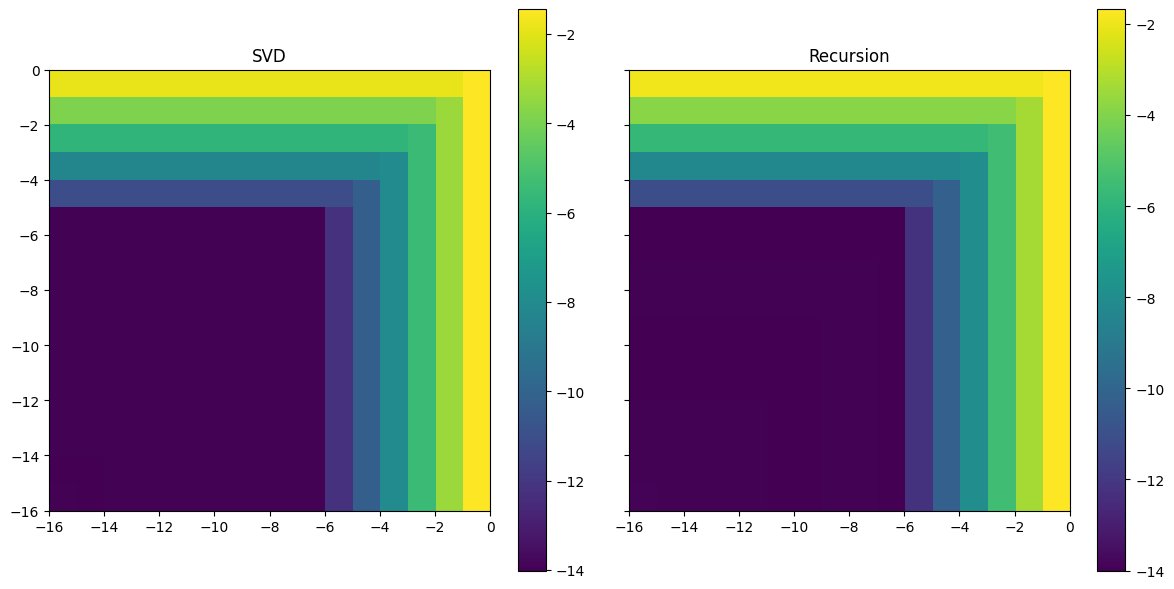

In [18]:
fig1, ax1 = subplots(1,2, sharey=True, figsize=(12,6))

im0 = ax1[0].imshow(log10(svd_errors), origin="lower",
                    extent=[-16,0,-16,0])
ax1[0].set_title("SVD")

im1 = ax1[1].imshow(log10(rec_errors), origin="lower",
                    extent=[-16,0,-16,0])
ax1[1].set_title("Recursion")

fig1.colorbar(im1)
fig1.colorbar(im0)

fig1.tight_layout()
show()

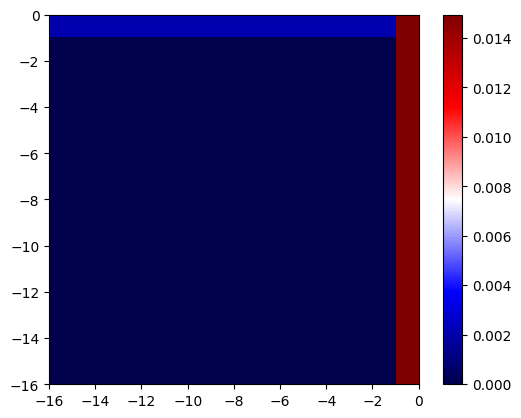

In [19]:
fig2, ax2 = subplots(1,1)

im = ax2.imshow(svd_errors-rec_errors,
                cmap=colormaps["seismic"],
                origin="lower",
                extent=[-16,0,-16,0])
fig2.colorbar(im)

show()

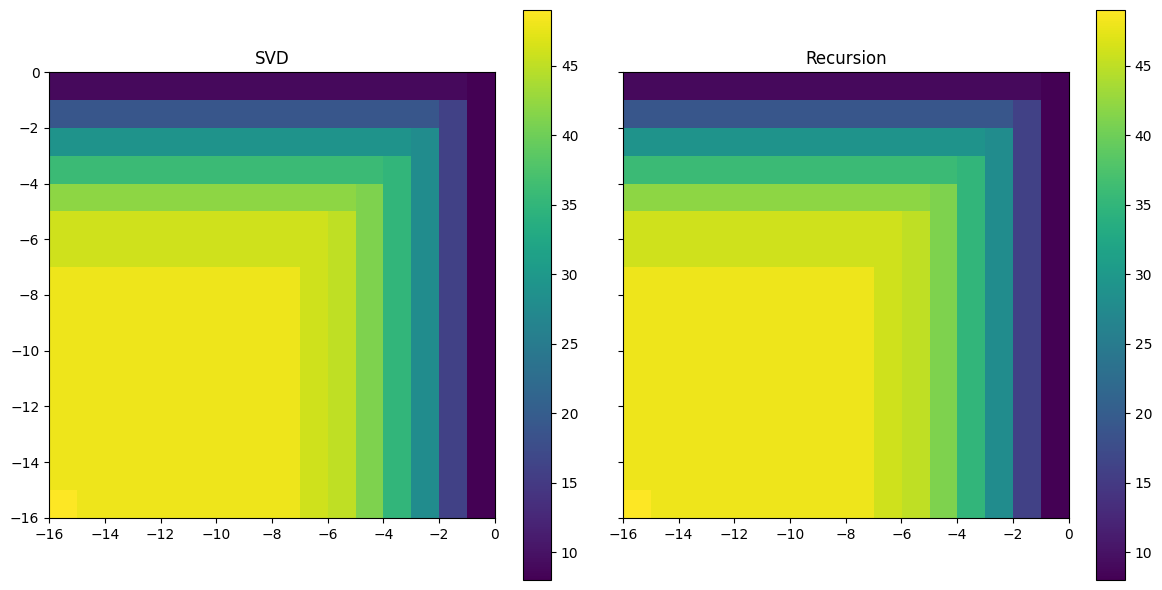

In [20]:
fig1, ax1 = subplots(1,2, sharey=True, figsize=(12,6))

im0 = ax1[0].imshow(svd_bond_dims, origin="lower",
                    extent=[-16,0,-16,0])
ax1[0].set_title("SVD")

im1 = ax1[1].imshow(rec_bond_dims, origin="lower",
                    extent=[-16,0,-16,0])
ax1[1].set_title("Recursion")

fig1.colorbar(im1)
fig1.colorbar(im0)

fig1.tight_layout()
show()

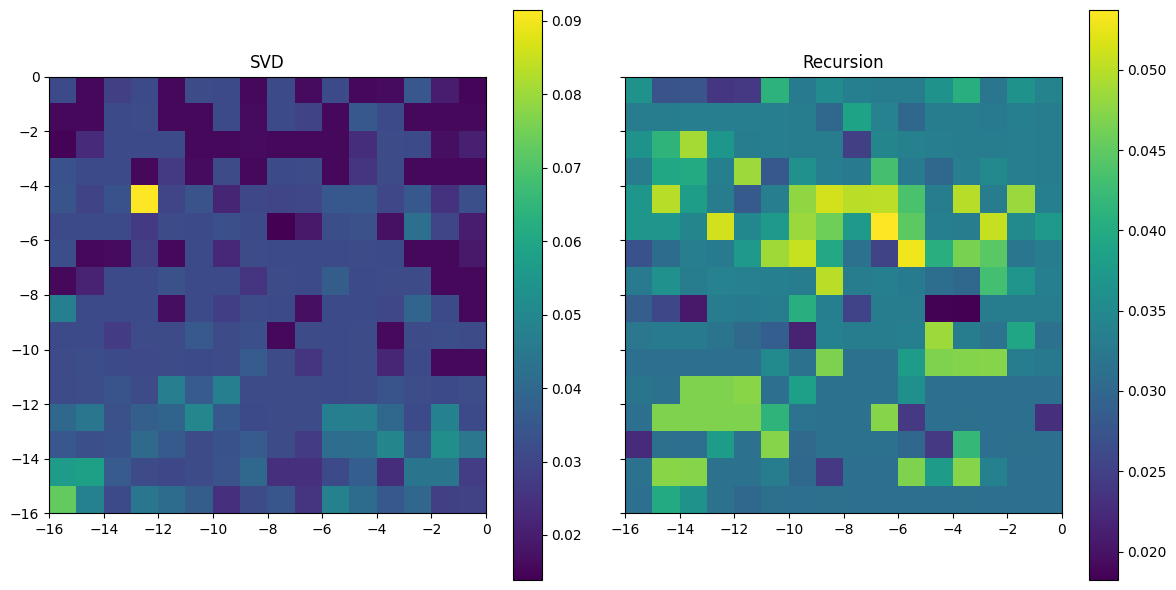

In [21]:
fig1, ax1 = subplots(1,2, sharey=True, figsize=(12,6))

im0 = ax1[0].imshow(svd_comp_times, origin="lower",
                    extent=[-16,0,-16,0])
ax1[0].set_title("SVD")

im1 = ax1[1].imshow(rec_comp_times, origin="lower",
                    extent=[-16,0,-16,0])
ax1[1].set_title("Recursion")

fig1.colorbar(im1)
fig1.colorbar(im0)

fig1.tight_layout()
show()

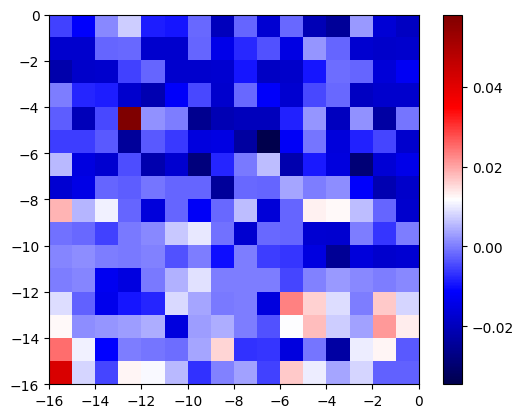

In [22]:
fig2, ax2 = subplots(1,1)

im = ax2.imshow(svd_comp_times-rec_comp_times,
                cmap=colormaps["seismic"],
                origin="lower",
                extent=[-16,0,-16,0])
fig2.colorbar(im)

show()

## FTPS

In [24]:
main_length = 4
sub_length = 4
ftps = ForkTreeProductState()
ket_0 = asarray([1,0], dtype=complex)
for main_index in range(main_length):
    if main_index in [0,main_length-1]:
        tensor = ket_0.reshape((1,1,2))
    else:
        tensor = ket_0.reshape((1,1,1,2))
    ftps.add_main_chain_node(tensor)
    for sub_index in range(sub_length):
        if sub_index == sub_length-1:
            tensor = ket_0.reshape((1,2))
        else:
            tensor = ket_0.reshape((1,1,2))
        ftps.add_sub_chain_node(tensor, main_index)
print(list(ftps.nodes.keys()))

['main0', 'sub0_0', 'sub0_1', 'sub0_2', 'sub0_3', 'main1', 'sub1_0', 'sub1_1', 'sub1_2', 'sub1_3', 'main2', 'sub2_0', 'sub2_1', 'sub2_2', 'sub2_3', 'main3', 'sub3_0', 'sub3_1', 'sub3_2', 'sub3_3']


In [25]:
hamiltonian = generate_full_conecction_hamiltonian(ftps)
ttno = TreeTensorNetworkOperator.from_hamiltonian(hamiltonian,ftps)

In [26]:
svd_params = SVDParameters(rel_tol=0.0,total_tol=0.0,max_bond_dim=150)
time_evo = SecondOrderTwoSiteTDVP(ftps, ttno, 0.1, 0.3, [], truncation_parameters=svd_params)
time_evo.run()
state = time_evo.state
state.canonical_form("root")

 50%|█████     | 2/4 [21:38<21:38, 649.33s/it]


MemoryError: Unable to allocate 16.0 GiB for an array with shape (32768, 32768) and data type complex128